<a href="https://colab.research.google.com/github/jose-zerna/Handwritten-Digit-Generation-with-Deep-Generative-Adversarial-Network/blob/main/Handwritten_Digit_Generation_with_Deep_Generative_Adversarial_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Handwritten Digit Generation with Deep Generative Adversarial Network
This project focuses on implementing a Deep Generative Adversarial Network (GAN) to generate realistic handwritten digits. The dataset used for training the generator is MNIST, which is a widely used dataset for handwritten digit recognition in computer vision tasks. You can access the MNIST dataset and its documentation at this link: https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html.

This project is available as a guided project on Coursera titled "Deep Learning with PyTorch: Generative Adversarial Network." You can access the project directly by visiting the following URL: https://www.coursera.org/projects/deep-learning-with-pytorch-generative-adversarial-network.

The main tasks involved in this project are as follows:

- Set the configurations for the neural network parameters, such as the batch size number, beta parameters, and learning rates.
- Load the MNIST Handwritten Dataset and apply data augmentation techniques to enhance the variety and diversity of the training data.
- Load the dataset into batches using the iterable DataLoader() provided by PyTorch to efficiently process the data during training.
- Create the Discriminator Network, which is responsible for distinguishing between real and generated handwritten digits.
- Create the Generator Network, which generates synthetic handwritten digits to fool the discriminator.
- Define the loss function (BCEWithLogitsLoss), and load the optimizers to train the GAN.
- Train the Generative Adversarial Network by iteratively updating the discriminator and generator networks to improve the quality of generated digits.

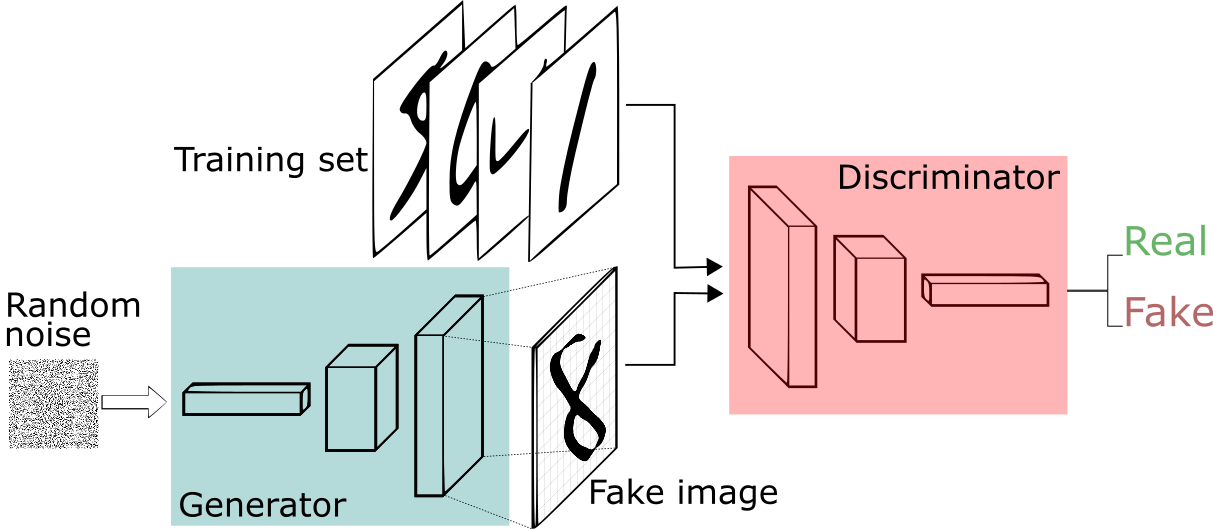

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' # to send an image to the device: image = image.to(device)
batch_size = 128 # will be used in trainloader, training_loop()
noise_dim = 64 # random noise vector dimension. Will be used in creating generator model

# optimizer parameters:
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# Training variables
epochs = 30

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor() # images will be in numpy images, need to convert to Torch tensor: (h,w,c) --> Torch conventional (c,h,w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/',download = True, train = True, transform = train_augs)

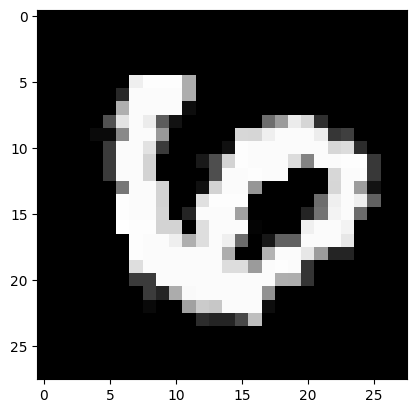

In [ ]:
image, label = trainset[9000]
plt.imshow(image.squeeze(), cmap = 'gray')

In [ ]:
print('Total images in trainset: ', len(trainset))

Total images in trainset:  60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)

In [ ]:
print('Total number of batches in trainloader: ', len(trainloader))

Total number of batches in trainloader:  469


In [ ]:
dataiter = iter(trainloader)
# images, _ = dataiter._next_() ---->  Old Torch version syntax
images, _ = next(dataiter)
print(images.shape)

# Result: torch.Size([128, 1, 28, 28]) ---> One batch contains 128 images

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

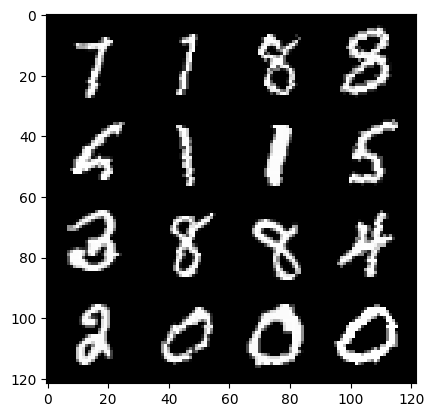

In [ ]:
show_tensor_images(images, num_images = 16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

'\n\nNetwork : Discriminator\n\ninput : (bs, 1, 28, 28)\n      |                                                                                               ---- SUMMARY ----\n      V\nConv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)\nBatchNorm2d()                                                                                          #(bs, 16, 13, 13)\nLeakyReLU()                                                                                            #(bs, 16, 13, 13)\n      |\n      V\nConv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)\nBatchNorm2d()                                                                                          #(bs, 32, 5, 5)\nLeakyReLU()                                                                                            #(bs, 32, 5, 5)\n      |\n      V\nConv2d( in_channels = 32, out_channels = 64, kernel

Let's build the discriminator network in blocks

In [ ]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
    nn.Conv2d(in_channels, out_channels, kernel_size, stride),
    nn.BatchNorm2d(out_channels),
    nn.LeakyReLU(0.2)
  )


In [ ]:
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

Sigmoid layer is not used, because we are going to use BCE with logit loss, which takes raw outputs, BCE with logit loss takes the raw output (without sigmoid activation), and in the loss funcion the sigmoid layer is applied.

In [ ]:
D = Discriminator()
D.to(device)

summary(D, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels,  kernel_size, stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)
    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, rand_noise_vec):

    #(bs, noise_dim) --> (bs, noise_dim, 1, 1)
    x = rand_noise_vec.view(-1, self.noise_dim, 1, 1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G, input_size = (1, noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D = D.apply(weights_init)
G = G.apply(weights_init)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [ ]:
D_opt = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6855664770486258 | G_loss : 0.6896510746941638


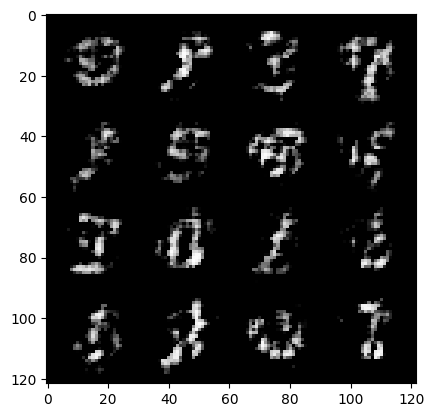

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6813047668064581 | G_loss : 0.7088908433660007


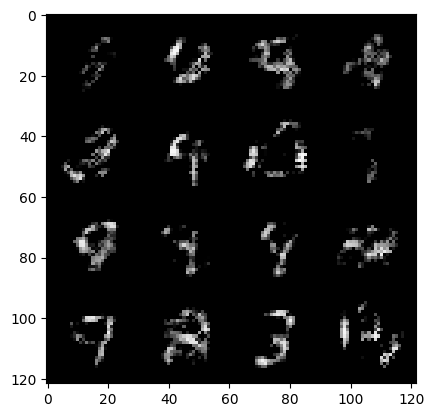

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6526131821847928 | G_loss : 0.7431305256733762


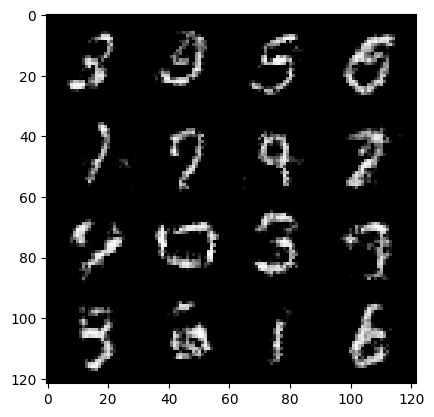

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6301600044724275 | G_loss : 0.7734999668115238


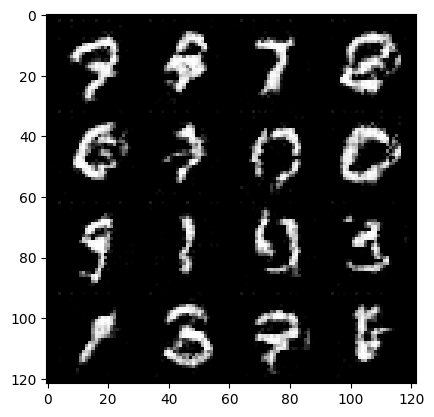

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6259111356633559 | G_loss : 0.7879207519325875


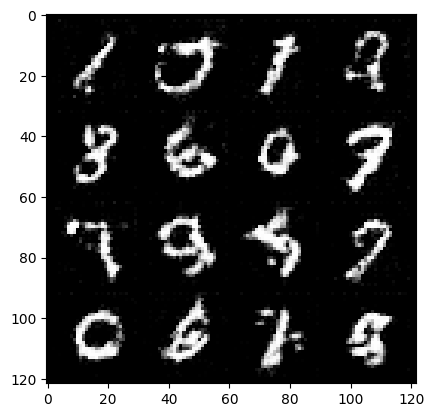

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6293249360279742 | G_loss : 0.7898779272524787


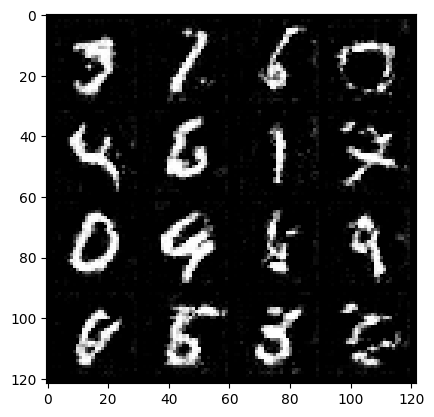

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6258571760486692 | G_loss : 0.8049413896064515


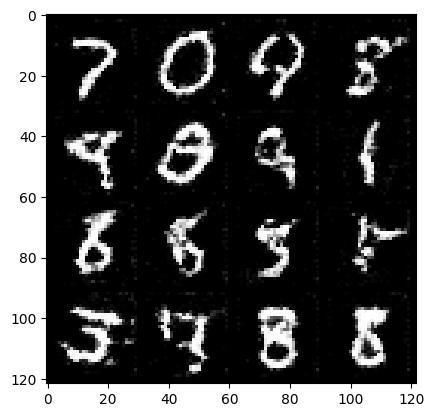

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6267745774437878 | G_loss : 0.8076519175633184


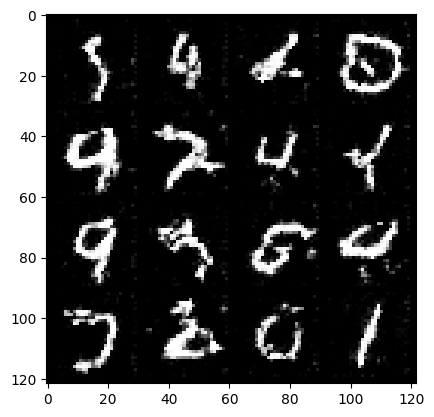

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6342608059393063 | G_loss : 0.8048061738644582


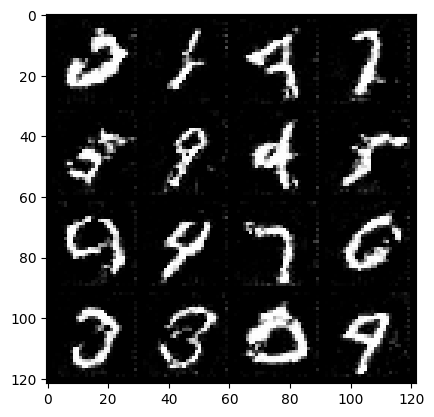

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.6414934699215106 | G_loss : 0.7982513480094958


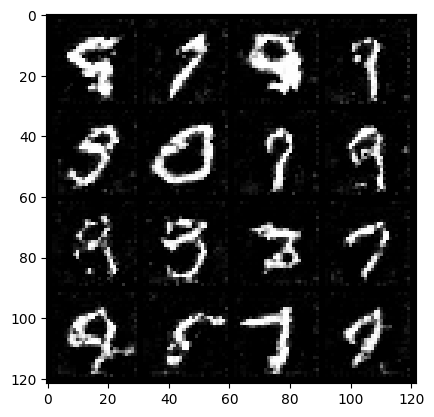

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.6438977142641031 | G_loss : 0.7981259076834233


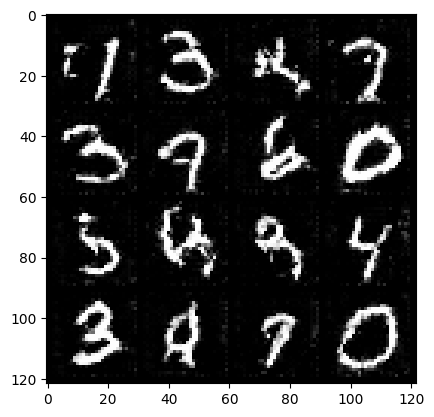

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.6476129862799573 | G_loss : 0.7899353753274946


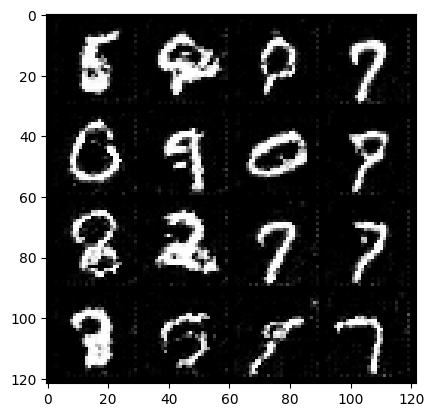

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.6482924206424624 | G_loss : 0.7919360570816089


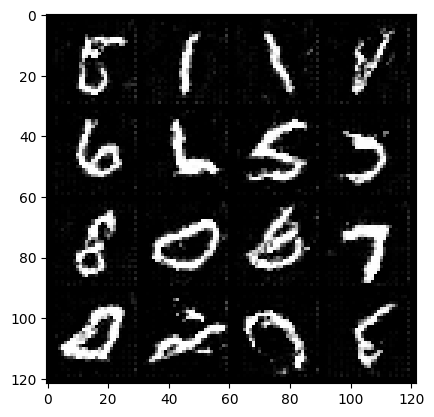

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.6489468262648024 | G_loss : 0.7902628870915248


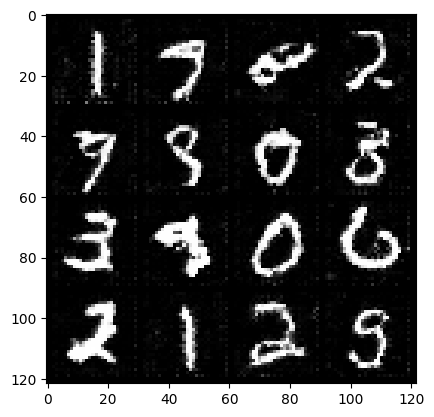

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.6481237410228136 | G_loss : 0.7924158364725011


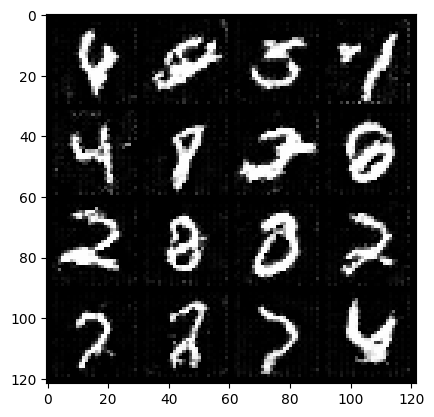

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.6493608602074418 | G_loss : 0.7916493194698017


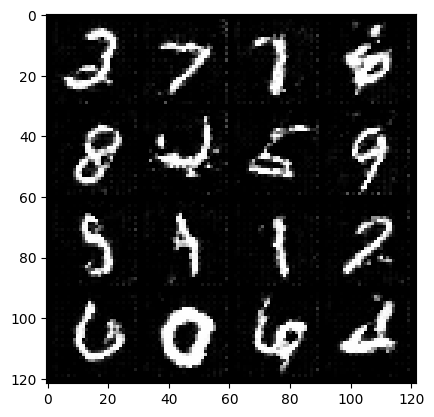

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.6495898834932079 | G_loss : 0.7923339513827489


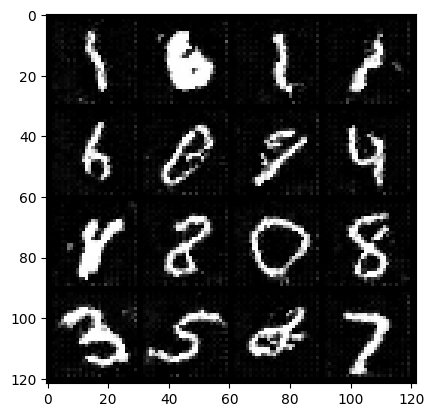

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.650530590050256 | G_loss : 0.7932343519826942


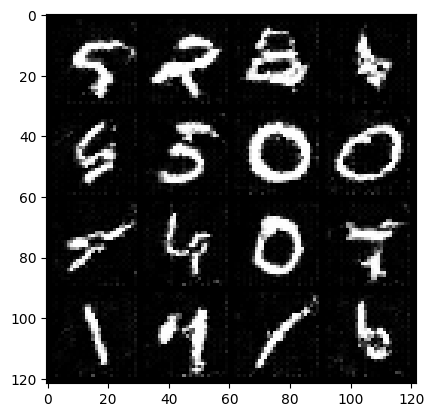

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.6513360122373617 | G_loss : 0.7939449771126704


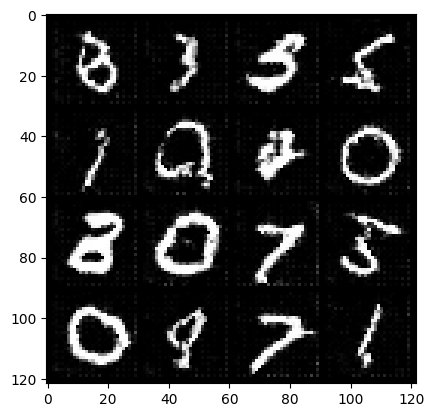

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.651602739718423 | G_loss : 0.7929605297696616


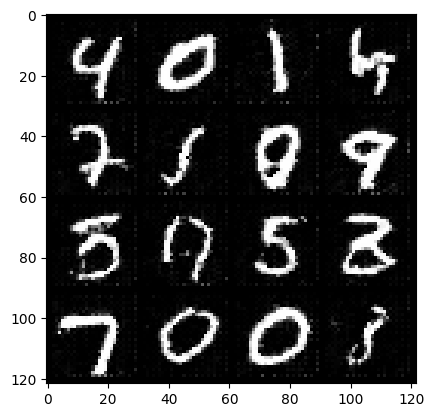

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 21 | D_loss : 0.6527550089588043 | G_loss : 0.791214800973945


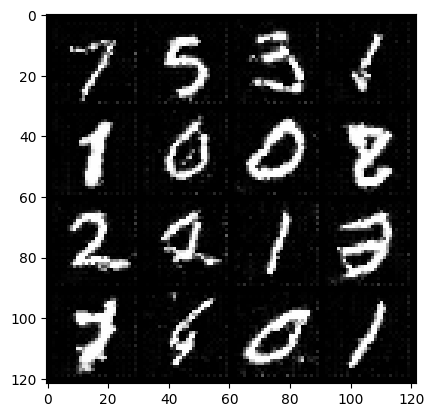

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 22 | D_loss : 0.6525037626721966 | G_loss : 0.7911530712774313


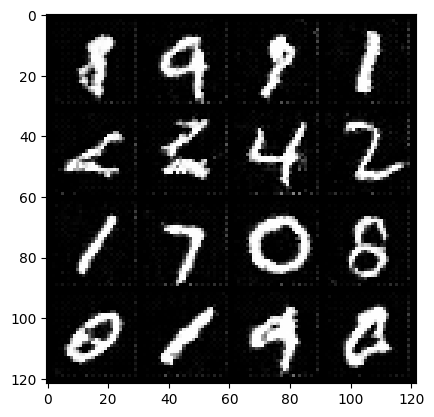

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 23 | D_loss : 0.6524679564209636 | G_loss : 0.792045179333514


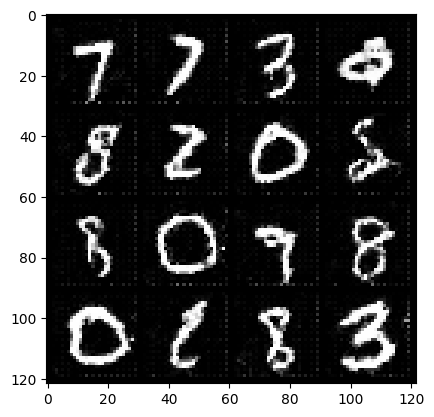

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 24 | D_loss : 0.6521432426438403 | G_loss : 0.7927348536214849


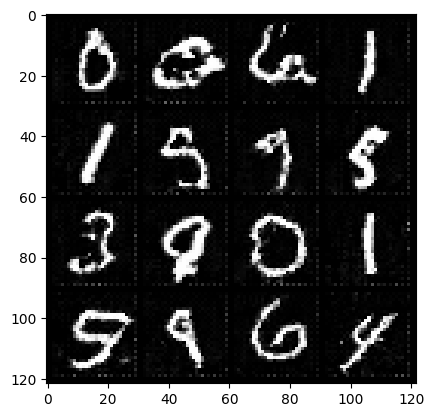

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 25 | D_loss : 0.6511275257383075 | G_loss : 0.795818676953631


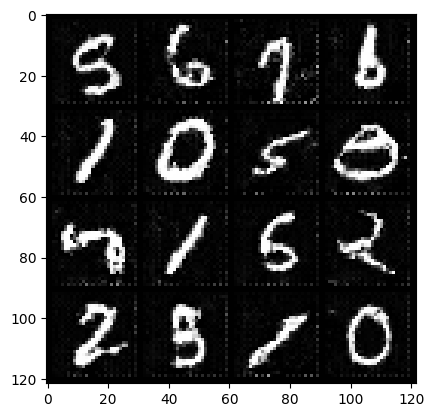

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 26 | D_loss : 0.6521847315434454 | G_loss : 0.795677274147839


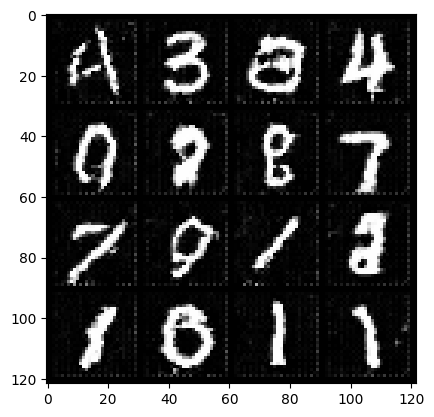

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 27 | D_loss : 0.651225688106724 | G_loss : 0.7969362454882054


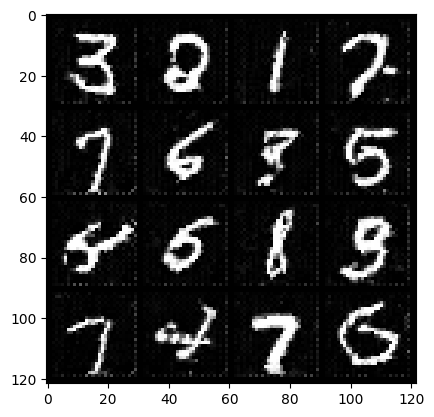

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 28 | D_loss : 0.6519978608149709 | G_loss : 0.7966530007848354


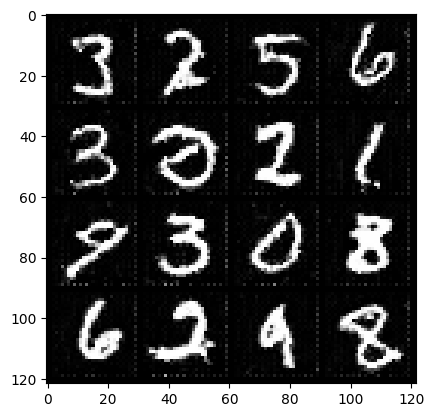

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 29 | D_loss : 0.6504085254567519 | G_loss : 0.7996880610360265


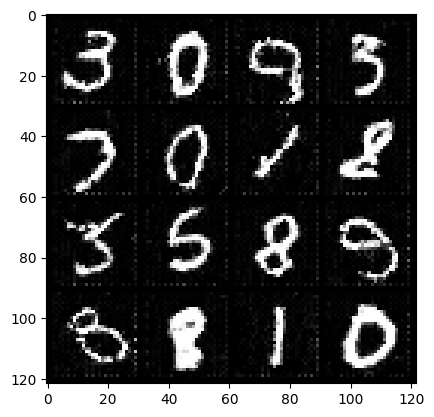

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 30 | D_loss : 0.6500434852612298 | G_loss : 0.8021869182840847


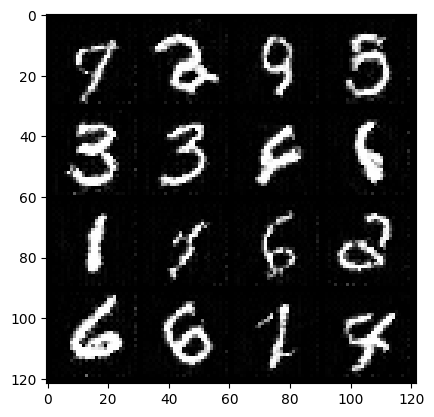

In [ ]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    real_img = real_img.to(device)
    noise = torch.randn(batch_size, noise_dim, device = device)

    # find loss and update weights for D:

    D_opt.zero_grad()  # to make sure gradients are zero
    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss) / 2

    total_d_loss += D_loss.item()

    # to find the gradients:
    D_loss.backward()

    # update weights of discrimitor network
    D_opt.step()


    # find loss and update weights for G:

    G_opt.zero_grad()
    noise = torch.randn(batch_size, noise_dim, device = device)

    fake_img = G(noise)
    D_pred = D(fake_img)

    # pass discriminator predictions to the real loss:
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print('Epoch : {} | D_loss : {} | G_loss : {}'.format(i+1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img)





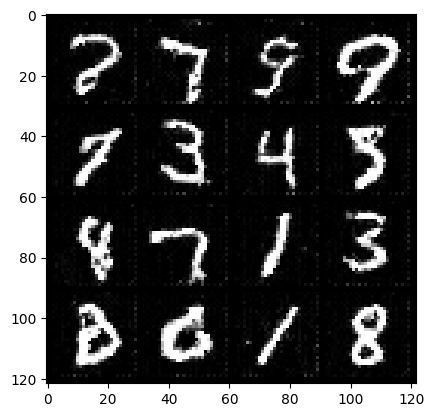

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)